# Introduction to Tensorflow : Set training pipeline
### By: Diego Coello de Portugal Mecke

This notebook aims to create model trainning pipeline without using standard tensorflow functionalities.

The data is synthetic (sinuosoidal function) with some outliers for test robustness of the model.
The training pipeline will be tested with a dataloader and a generator to prove the generality of the implemented functionalities.

The usage of regularization and gradient clipping will be tested for the case with outliers, showing a comparison of the performance of the different settings.

----

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten, Conv2D
from tensorflow.keras import Model, regularizers
import numpy as np
import pandas as pd
import pickle as pk
import matplotlib.pyplot as plt
#from google.colab import drive

print(tf.__version__)
print(np.__version__)
print(pd.__version__)

2.12.0
1.22.4
1.5.3


In [2]:
#Set seeds for reproducibility
seed = 21

tf.random.set_seed(seed)

np.random.state = seed
np.random.seed = seed

## Data Loader

In [3]:
def loadData(n=16000, outliers=False):

    # Get data
    x = np.random.rand(n,1)*2*np.pi-np.pi
    y = np.sin(x)

    # Add outliers
    if outliers:
        y[np.random.randint(0,n,3)]=1000.

    return x , y

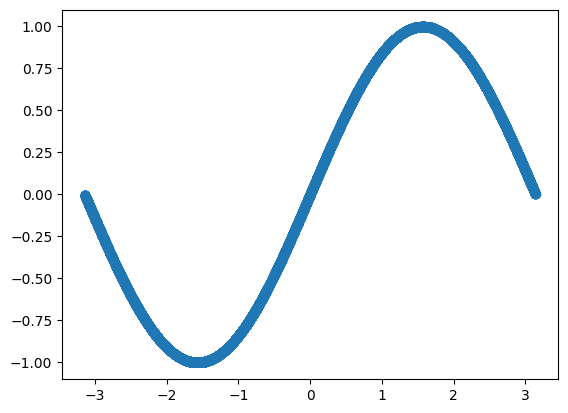

In [4]:
x,y = loadData()
plt.scatter(x,y)

## Create a class to define and use model

In [5]:
# Implementation of simple feedforward network
class FCNet(Model):
    def __init__(self, neurons=[12,12,3], reg=None,activation="relu"):
        super(FCNet, self).__init__()

        self.denseLayers=[]
        for idx,neuron in enumerate(neurons):
            self.denseLayers.append(Dense(neuron, activation="relu"))

        self.outputLayer = Dense(1, activation=None)

    def call(self, input_x):
        output = input_x

        for layer in self.denseLayers:
            output = layer(output)

        return self.outputLayer(output)

## Optimization routine

In [6]:
class TrainModel:

    def __init__(self, model, batch_size = 8, lr = 0.001, loss = tf.keras.losses.MeanSquaredError, opt=tf.keras.optimizers.Adam):

        self.model      = model
        self.loss       = loss()
        self.optimizer  = opt(learning_rate = lr)
        self.batch_size = batch_size

        self.train_loss = tf.keras.metrics.Mean(name='train_loss')

        self.test_loss  = tf.keras.metrics.Mean(name='test_loss')


    @tf.function
    def train_step(self, x , y):
        with tf.GradientTape() as tape:
            predictions = self.model(x) #Update
            loss = self.loss(y, predictions)

        gradients = tape.gradient(loss, self.model.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.model.trainable_variables))
        self.train_loss.update_state(loss)
        return loss

    @tf.function
    def test_step(self, x , y):
        predictions = self.model(x)
        loss = self.loss(y, predictions)
        self.test_loss.update_state(loss)
        return loss

    def train(self):
        loss = []
        for bX, bY in self.train_ds:
            loss.append(self.train_step(bX, bY))
        return loss

    def test(self):
        loss = []
        for bX, bY in self.test_ds:
            loss.append(self.test_step(bX, bY))
        return loss

    def run(self, dataX, dataY, testX, testY, epochs, verbose=1):
        history = []

        self.train_ds = tf.data.Dataset.from_tensor_slices((dataX, dataY)).shuffle(16000).batch(self.batch_size)
        self.test_ds  = tf.data.Dataset.from_tensor_slices((testX,testY)).batch(self.batch_size)

        for i in range(epochs):

            train_loss = self.train()
            test_loss  = self.test()

            history.append([train_loss,test_loss])

            if verbose > 0 and (i==0 or (i+1)%5==0):

                print(f"epoch: {i+1}, TRAIN LOSS: {self.train_loss.result()}, TEST LOSS: {self.test_loss.result()}")

                self.train_loss.reset_states()
                self.test_loss.reset_states()

        return history

In [7]:
x_train, y_train = loadData()
x_test, y_test  = loadData()

model = FCNet()
opt   = TrainModel(model, batch_size=8, lr=0.001, loss=tf.keras.losses.MeanSquaredError, opt=tf.keras.optimizers.SGD)

hist = opt.run(x_train, y_train, x_test, y_test, epochs=20, verbose=1)
hist = np.array(hist)

epoch: 1, TRAIN LOSS: 0.27682164311408997, TEST LOSS: 0.22091352939605713
epoch: 5, TRAIN LOSS: 0.15422481298446655, TEST LOSS: 0.14093171060085297
epoch: 10, TRAIN LOSS: 0.0678289383649826, TEST LOSS: 0.06077185645699501
epoch: 15, TRAIN LOSS: 0.023756669834256172, TEST LOSS: 0.020715389400720596
epoch: 20, TRAIN LOSS: 0.00712821027263999, TEST LOSS: 0.006114550866186619


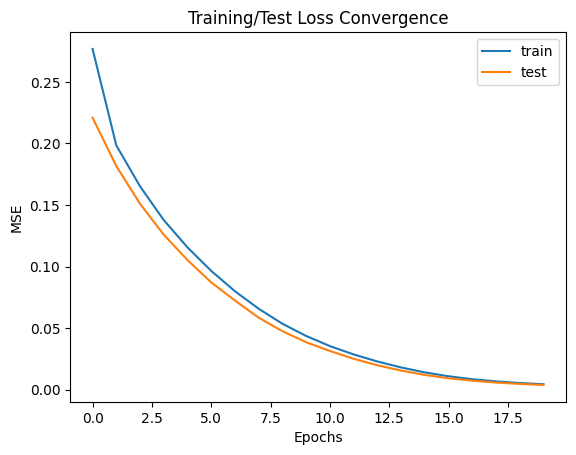

In [8]:
plt.plot(np.mean(hist,-1)[:,0],label="train")
plt.plot(np.mean(hist,-1)[:,1],label="test")
plt.xlabel("Epochs")
plt.ylabel("MSE")
plt.title("Training/Test Loss Convergence")
plt.legend()

## Data generator

In [9]:
def genData(batch_size=100):
    while True:
        x = np.random.rand(batch_size,1)*2*np.pi-np.pi
        y = np.sin(x)
        yield x , y

In [10]:
#Definition of RunModel class (variation of TrainClass with new run method)
class RunModel:

    def __init__(self, model, batch_size=8, lr=0.001, loss=tf.keras.losses.MeanSquaredError, opt=tf.keras.optimizers.Adam):

        self.model      = model
        self.loss       = loss()
        self.optimizer  = opt(learning_rate = lr)
        self.batch_size = batch_size

        self.train_loss = tf.keras.metrics.Mean(name='train_loss')
        self.test_loss  = tf.keras.metrics.Mean(name='test_loss')


    @tf.function
    def train_step(self, x , y):
        with tf.GradientTape() as tape:
            inp = tf.convert_to_tensor([x], dtype=tf.float64)
            out = tf.convert_to_tensor([y], dtype=tf.float64)
            predictions = model(inp)
            loss = self.loss(out, predictions)

        gradients = tape.gradient(loss, self.model.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.model.trainable_variables))
        self.train_loss.update_state(loss)
        return loss

    @tf.function
    def test_step(self, x , y):
        predictions = self.model(x)
        loss = self.loss(y, predictions)
        self.test_loss.update_state(loss)
        return loss

    def train(self):
        loss = []
        for bX, bY in self.train_ds:
            loss.append(self.train_step(bX, bY))
        return loss

    def test(self):
        loss = []
        for bX, bY in self.test_ds:
            loss.append(self.test_step(bX, bY))
        return loss

    def run(self, trainGen, testGen, epochs, verbose=2): #Update
        history = []
        batch_size = (next(trainGen)[0]).shape[0] #Update

        for i in range(epochs):
            self.train_ds = tf.data.Dataset.from_tensor_slices(next(train_gen)).batch(batch_size) #Update
            self.test_ds  = tf.data.Dataset.from_tensor_slices(next(test_gen)).batch(batch_size) #Update

#             self.train_ds = tf.data.Dataset.from_generator(train_gen)
#             self.test_ds  = tf.data.Dataset.from_generator(test_gen)

            train_loss = self.train()
            test_loss  = self.test()

            history.append([train_loss,test_loss])

            if verbose > 0 and (i==0 or (i+1)%5==0):
                print(f"epoch: {i+1}, TRAIN LOSS: {self.train_loss.result()}, TEST LOSS: {self.test_loss.result()}")

                self.train_loss.reset_states()
                self.test_loss.reset_states()

        return history

In [11]:
train_gen = genData(batch_size=16000)
test_gen  = genData(batch_size=16000)

# Running this requires to update RunModel
model  = FCNet()
opt    = RunModel(model, lr=0.001, loss=tf.keras.losses.MeanSquaredError, opt=tf.keras.optimizers.SGD)

hist = opt.run(train_gen, test_gen, 30, verbose=1)
hist = np.array(hist)

epoch: 1, TRAIN LOSS: 0.5108892917633057, TEST LOSS: 0.5052682161331177
epoch: 5, TRAIN LOSS: 0.501573920249939, TEST LOSS: 0.5006721615791321
epoch: 10, TRAIN LOSS: 0.49090248346328735, TEST LOSS: 0.49154648184776306
epoch: 15, TRAIN LOSS: 0.4782676696777344, TEST LOSS: 0.4757290780544281
epoch: 20, TRAIN LOSS: 0.4694285988807678, TEST LOSS: 0.46880799531936646
epoch: 25, TRAIN LOSS: 0.4585481584072113, TEST LOSS: 0.457615464925766
epoch: 30, TRAIN LOSS: 0.4491928219795227, TEST LOSS: 0.44794052839279175


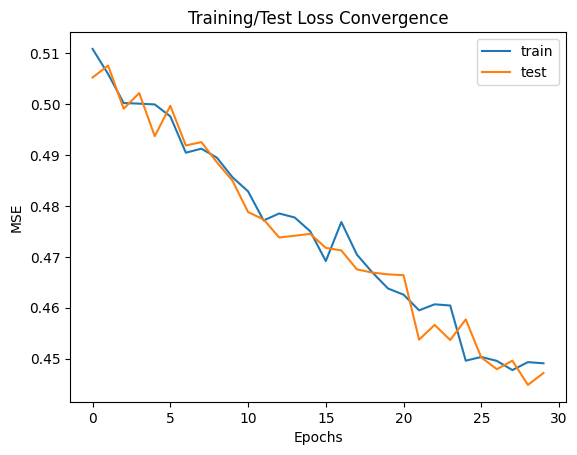

In [12]:
plt.plot(np.mean(hist,-1)[:,0],label="train")
plt.plot(np.mean(hist,-1)[:,1],label="test")
plt.xlabel("Epochs")
plt.ylabel("MSE")
plt.title("Training/Test Loss Convergence")
plt.legend()

The result difference between the generator and the numpy case are due to the difference in data. One epoch of the generator has 8 instances, while the generator has 16000 instances.

## Test L2 regularization and gradient clipping by norm to the model.

Test implementations by running the original code with outliers in the data.

In [13]:
xn_train, yn_train = loadData(outliers=True)
x_test, y_test   = loadData()

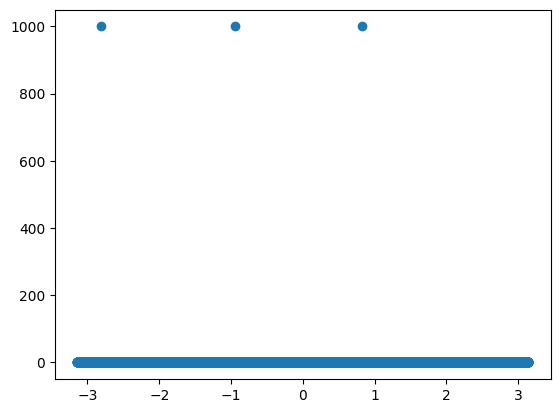

In [14]:
plt.scatter(xn_train, yn_train)

Add regularization in the layers

In [15]:
# Implementation of simple feedforward network with regularization
class FCNet2(Model):
    def __init__(self, neurons=[12,12,3], reg=0.001, activation="relu"): #Update
        super(FCNet2, self).__init__()

        self.denseLayers=[]
        for idx,neuron in enumerate(neurons):
            self.denseLayers.append(Dense(neuron, kernel_regularizer=regularizers.l2(reg), activation="relu")) #Update

        self.outputLayer = Dense(1, kernel_regularizer=regularizers.l2(reg), activation=None)

    def call(self, input_x):
        output = input_x

        for layer in self.denseLayers:
            output = layer(output)

        return self.outputLayer(output)


Adding clipvalue to the optimizer.

In [16]:
class TrainModel2:

    def __init__(self, model, batch_size=8, lr=0.001, loss=tf.keras.losses.MeanSquaredError, opt=tf.keras.optimizers.Adam,\
                clip_value=1.0):

        self.model      = model
        self.loss       = loss()
        self.optimizer  = opt(learning_rate=lr, clipvalue=clip_value) #Update
        self.batch_size = batch_size

        self.train_loss = tf.keras.metrics.Mean(name='train_loss')

        self.test_loss  = tf.keras.metrics.Mean(name='test_loss')


    @tf.function
    def train_step(self, x , y):
        with tf.GradientTape() as tape:
            predictions = self.model(x)
            loss = self.loss(y, predictions) + sum(self.model.losses)

        gradients = tape.gradient(loss, self.model.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients,self.model.trainable_variables))
        self.train_loss.update_state(loss)
        return loss

    @tf.function
    def test_step(self, x , y):
        predictions = self.model(x)
        loss = self.loss(y, predictions)
        self.test_loss.update_state(loss)
        return loss

    def train(self):
        loss = []
        for bX, bY in self.train_ds:
            loss.append(self.train_step(bX, bY))
        return loss

    def test(self):
        loss = []
        for bX, bY in self.test_ds:
            loss.append(self.test_step(bX, bY))
        return loss

    def run(self, dataX, dataY, testX, testY, epochs, verbose=2):
        history = []

        self.train_ds = tf.data.Dataset.from_tensor_slices((dataX, dataY)).shuffle(16000).batch(self.batch_size)
        self.test_ds  = tf.data.Dataset.from_tensor_slices((testX,testY)).batch(self.batch_size)

        for i in range(epochs):

            train_loss = self.train()
            test_loss  = self.test()

            history.append([train_loss,test_loss])

            if verbose > 0 and (i==0 or (i+1)%5==0):
                print(f"epoch: {i+1}, TRAIN LOSS: {self.train_loss.result()}, TEST LOSS: {self.test_loss.result()}")


                self.train_loss.reset_states()
                self.test_loss.reset_states()

        return history

## Base model

In [17]:
model = FCNet()

opt = TrainModel(model, batch_size=8, lr=0.0001, loss=tf.keras.losses.MeanSquaredError, opt=tf.keras.optimizers.Adam)

hist = opt.run(xn_train, yn_train, x_test, y_test, 30, verbose=1)
hist = np.array(hist)

epoch: 1, TRAIN LOSS: 187.94696044921875, TEST LOSS: 0.3773564398288727
epoch: 5, TRAIN LOSS: 187.92098999023438, TEST LOSS: 0.34545403718948364
epoch: 10, TRAIN LOSS: 187.88633728027344, TEST LOSS: 0.30859947204589844
epoch: 15, TRAIN LOSS: 187.8550567626953, TEST LOSS: 0.23845922946929932
epoch: 20, TRAIN LOSS: 187.78439331054688, TEST LOSS: 0.19784754514694214
epoch: 25, TRAIN LOSS: 187.7519073486328, TEST LOSS: 0.17500485479831696
epoch: 30, TRAIN LOSS: 187.72509765625, TEST LOSS: 0.1548641324043274


------Base model for outliers------


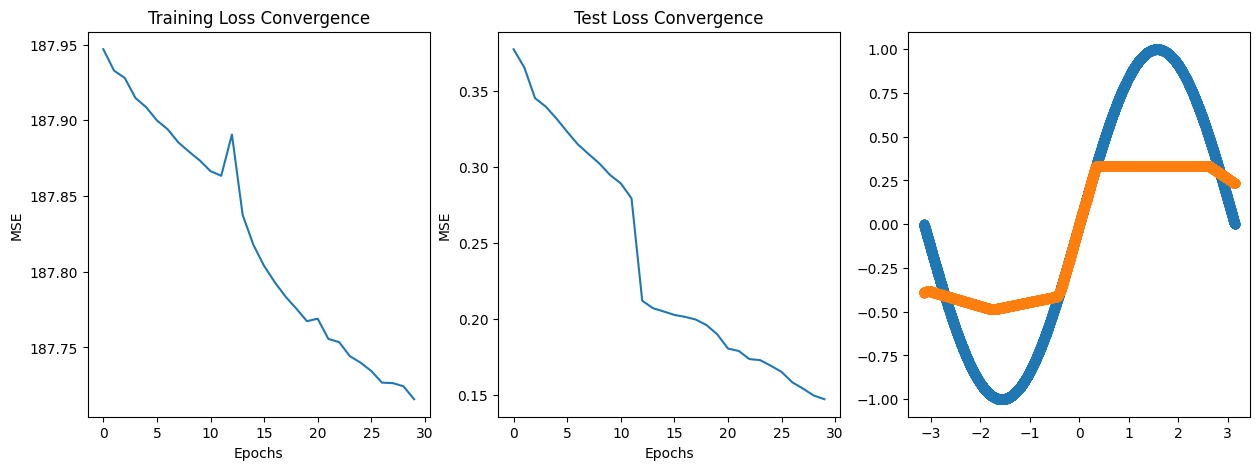

In [18]:
fig, axs = plt.subplots(1,3,figsize=(15,5))

print('------Base model for outliers------')

axs[0].plot(np.mean(hist,-1)[:,0],label="train")
axs[0].set_title("Training Loss Convergence")
axs.flat[0].set(xlabel='Epochs', ylabel='MSE')

axs[1].plot(np.mean(hist,-1)[:,1],label="test")
axs[1].set_title("Test Loss Convergence")
axs.flat[1].set(xlabel='Epochs', ylabel='MSE')

axs[2].scatter(x_test,y_test,label="true")
axs[2].scatter(x_test, model(x_test),label="pred")

## Model result with regularization

In [19]:
model = FCNet2(reg=0.001)

opt = TrainModel(model, batch_size=8, lr=0.0001, loss=tf.keras.losses.MeanSquaredError, opt=tf.keras.optimizers.Adam)

hist = opt.run(xn_train, yn_train, x_test, y_test, 30, verbose=1)
hist = np.array(hist)

epoch: 1, TRAIN LOSS: 187.86294555664062, TEST LOSS: 0.1530640572309494
epoch: 5, TRAIN LOSS: 187.69244384765625, TEST LOSS: 0.12997174263000488
epoch: 10, TRAIN LOSS: 187.6298828125, TEST LOSS: 0.09629351645708084
epoch: 15, TRAIN LOSS: 187.59445190429688, TEST LOSS: 0.08779479563236237
epoch: 20, TRAIN LOSS: 187.5850830078125, TEST LOSS: 0.08592963218688965
epoch: 25, TRAIN LOSS: 187.57696533203125, TEST LOSS: 0.08725448697805405
epoch: 30, TRAIN LOSS: 187.5674285888672, TEST LOSS: 0.0864284560084343


------Model result with regularization for outliers------


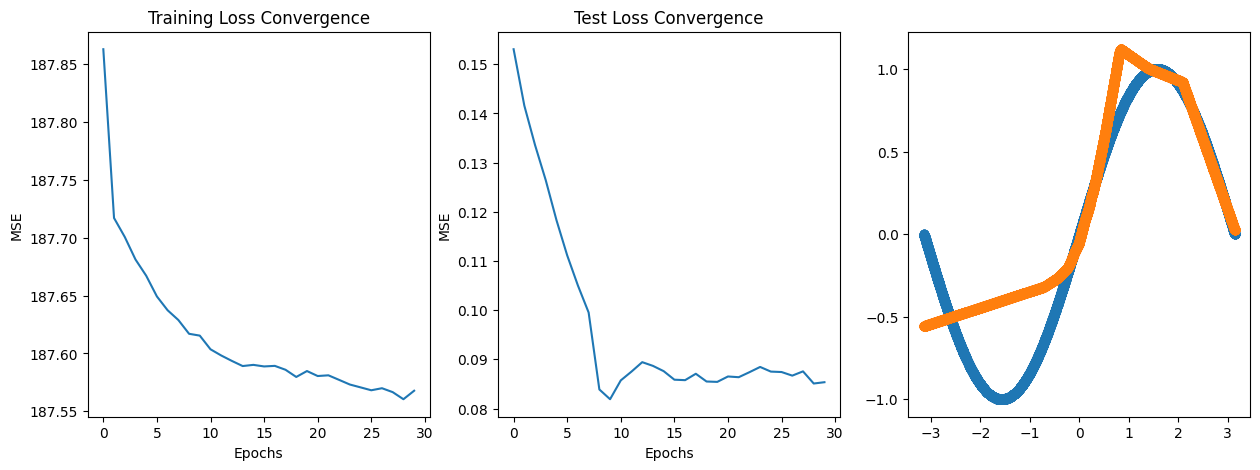

In [20]:
fig, axs = plt.subplots(1,3,figsize=(15,5))

print('------Model result with regularization for outliers------')

axs[0].plot(np.mean(hist,-1)[:,0],label="train")
axs[0].set_title("Training Loss Convergence")
axs.flat[0].set(xlabel='Epochs', ylabel='MSE')

axs[1].plot(np.mean(hist,-1)[:,1],label="test")
axs[1].set_title("Test Loss Convergence")
axs.flat[1].set(xlabel='Epochs', ylabel='MSE')

axs[2].scatter(x_test,y_test,label="true")
axs[2].scatter(x_test, model(x_test),label="pred")

The model with regularization has comparable results to the model without regularization. Due to bad initialization, both of them could collapse to predict always 0. In general, the regularization one has a little better performance.

## Model trainning with gradient clipping

In [30]:
model = FCNet()

opt = TrainModel2(model, batch_size=8, lr=0.0001, loss=tf.keras.losses.MeanSquaredError, opt=tf.keras.optimizers.Adam,\
                clip_value=2.0)

hist = opt.run(xn_train, yn_train, x_test, y_test, 30, verbose=1)
hist = np.array(hist)

epoch: 1, TRAIN LOSS: 187.76148986816406, TEST LOSS: 0.16636446118354797
epoch: 5, TRAIN LOSS: 187.6920928955078, TEST LOSS: 0.09918327629566193
epoch: 10, TRAIN LOSS: 187.6091766357422, TEST LOSS: 0.04236102104187012
epoch: 15, TRAIN LOSS: 187.59400939941406, TEST LOSS: 0.01975938491523266
epoch: 20, TRAIN LOSS: 187.58163452148438, TEST LOSS: 0.008999227546155453
epoch: 25, TRAIN LOSS: 187.5745849609375, TEST LOSS: 0.004460797179490328
epoch: 30, TRAIN LOSS: 187.56565856933594, TEST LOSS: 0.0023369488772004843


------Model result with gradient clipping for outliers------


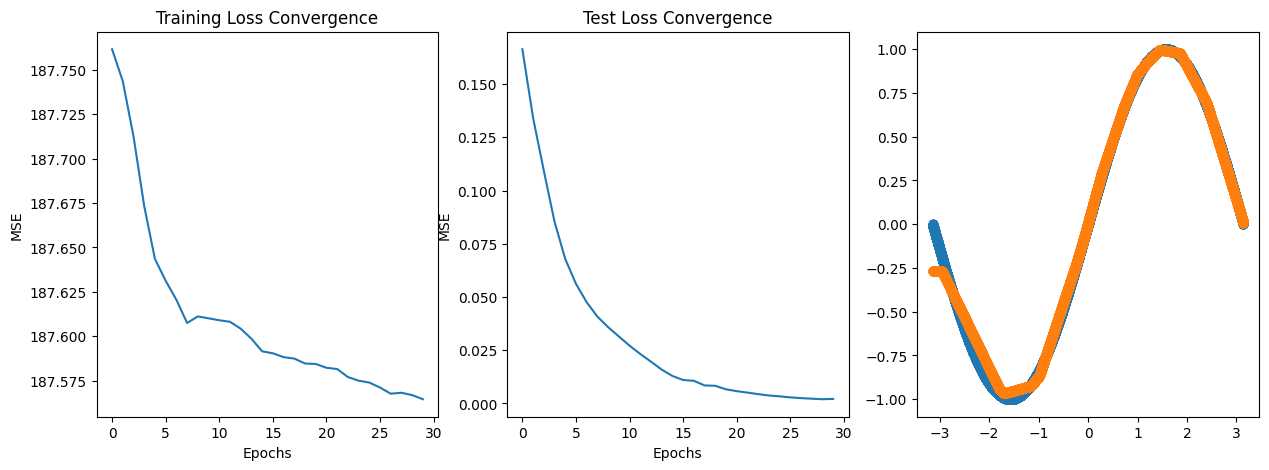

In [31]:
fig, axs = plt.subplots(1,3,figsize=(15,5))

print('------Model result with gradient clipping for outliers------')

axs[0].plot(np.mean(hist,-1)[:,0],label="train")
axs[0].set_title("Training Loss Convergence")
axs.flat[0].set(xlabel='Epochs', ylabel='MSE')

axs[1].plot(np.mean(hist,-1)[:,1],label="test")
axs[1].set_title("Test Loss Convergence")
axs.flat[1].set(xlabel='Epochs', ylabel='MSE')

axs[2].scatter(x_test,y_test,label="true")
axs[2].scatter(x_test, model(x_test),label="pred")

## Model trainning with gradient clipping and regularization

In [28]:
model = FCNet2(reg=0.001)

opt = TrainModel2(model, batch_size=8, lr=0.0001, loss=tf.keras.losses.MeanSquaredError, opt=tf.keras.optimizers.Adam,\
                clip_value=2.0)

hist = opt.run(xn_train, yn_train, x_test, y_test, 30, verbose=1)
hist = np.array(hist)

epoch: 1, TRAIN LOSS: 188.02442932128906, TEST LOSS: 0.13316652178764343
epoch: 5, TRAIN LOSS: 187.65280151367188, TEST LOSS: 0.04862403869628906
epoch: 10, TRAIN LOSS: 187.57691955566406, TEST LOSS: 0.005597920157015324
epoch: 15, TRAIN LOSS: 187.56344604492188, TEST LOSS: 0.0013833681587129831
epoch: 20, TRAIN LOSS: 187.5565643310547, TEST LOSS: 0.000666699605062604
epoch: 25, TRAIN LOSS: 187.5560302734375, TEST LOSS: 0.0006324658170342445
epoch: 30, TRAIN LOSS: 187.55479431152344, TEST LOSS: 0.000594328623265028


------Model result with regularization and gradient clipping for outliers------


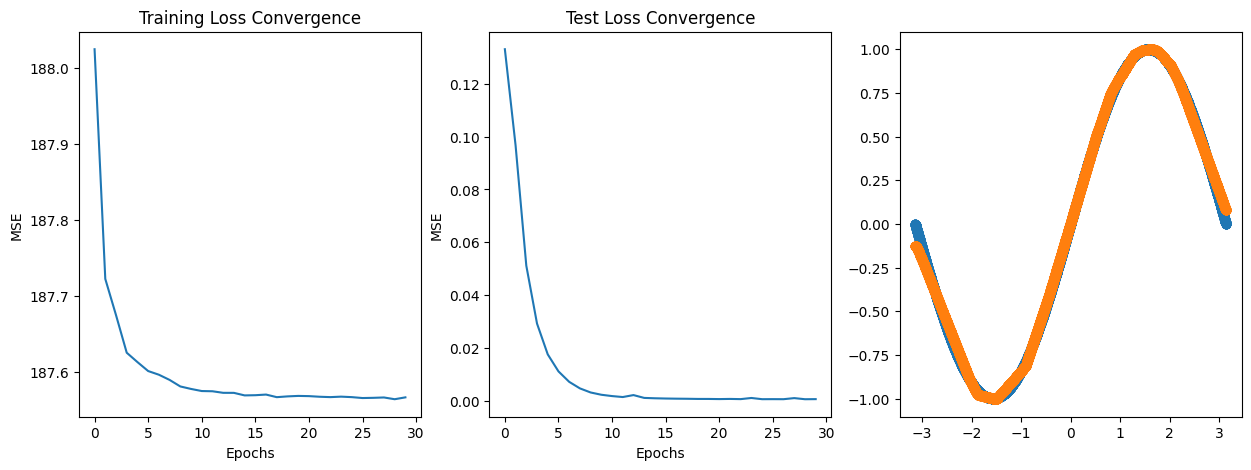

In [29]:
fig, axs = plt.subplots(1,3,figsize=(15,5))

print('------Model result with regularization and gradient clipping for outliers------')

axs[0].plot(np.mean(hist,-1)[:,0],label="train")
axs[0].set_title("Training Loss Convergence")
axs.flat[0].set(xlabel='Epochs', ylabel='MSE')

axs[1].plot(np.mean(hist,-1)[:,1],label="test")
axs[1].set_title("Test Loss Convergence")
axs.flat[1].set(xlabel='Epochs', ylabel='MSE')

axs[2].scatter(x_test,y_test,label="true")
axs[2].scatter(x_test, model(x_test), label="pred")

## Results and conclusions:

| *Loss* | Clipping | No clipping |
| --- | --- | --- |
| Regularization | **0.00059** | 0.08642 |
| No Regularization | 0.00233 | 0.15486 |

After some quick testing for hyperparameter tunning, regularization doesn't seem to have such a big influence for performance compared to gradient clipping.

This is consistent to the idea that regularization aims to avoid overfitting, while gradient clipping is more suitable to avoid the model diverging due to poissoned data.

## Rewriting the code to different files according to their names and purpose:

- data_loading.py
- model.py
- train.py
- run.py

In [ ]:
#When using google drive
from google.colab import drive
import sys
drive.mount('/content/gdrive', force_remount=True)
sys.path.append('/content/gdrive/My Drive/') # CHANGE THIS LINE DEPENDING OF WHERE YOU PUT YOUR FILES IN GOOGLE DRIVE

from run import run_experiment
run_experiment()

epoch: 1, TRAIN LOSS: 181.79122924804688, TEST LOSS: 0.10310038924217224
epoch: 10, TRAIN LOSS: 181.86300659179688, TEST LOSS: 0.008465747348964214
epoch: 20, TRAIN LOSS: 181.66650390625, TEST LOSS: 0.0006221205112524331
epoch: 30, TRAIN LOSS: 181.67843627929688, TEST LOSS: 0.0004937461344525218


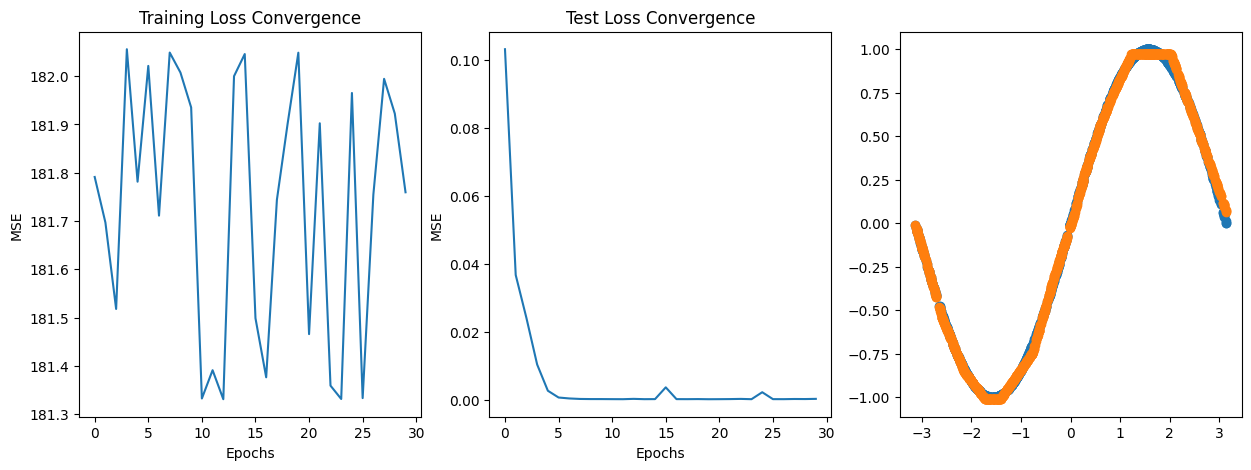

In [32]:
#When loading from local folder
from python_files.run import run_experiment
run_experiment()